# Segmenting Buildings on Drone Imagery with CNN & Cloud-Native GeoData Tools

Source : **by [@daveluo](https://github.com/daveluo)**
Source : [Google Colab Notebook](https://colab.research.google.com/github/daveluo/zanzibar-aerial-mapping/blob/master/geo_fastai_tutorial01_public_v1.ipynb) and accompanying 
Source : [Medium post](https://medium.com/@anthropoco/how-to-segment-buildings-on-drone-imagery-with-fast-ai-cloud-native-geodata-tools-ae249612c321?source=friends_link&sk=57b82002ac47724ecf9a2aaa98de994b),


This notebook1 will be a step by step procedure to processing a satellite image.There is a follow up notebook2  for training and validating on data.
Firstly we will get a grasp of what type of image we are using and what are the complications with it. 
We are going to use a geotiff image for this, and the corresponding mask will be of the form of geojson.
The image is taken from [2018 Open AI Tanzania building footprint segmentation challange](https://docs.google.com/spreadsheets/d/1kHZo2KA0-VtCCcC5tL4N0SpyoxnvH7mLbybZIHZGTfE/edit#gid=0)and we will divide the tiff image and its corresponding geojson mask into tiles and these tiles are the training images for our CNN. (tiles for now can be considered as images with relativelylower sizes), in our case( 256 * 256 ). These tiles can be stiched back into the original tiff image. 

The coordinates are also preserved in this process, ie we can know exactly which part of the world this data is take from. 
The training and validation data that we will discuss later will be taken from one image. Some part of image is used for training and some part of the same image is used or
validation
For this we'll use the [Tanzania Open AI Challenge dataset](https://competitions.codalab.org/competitions/20100#learn_the_details) of 7-cm resolution drone imagery and building footprint labels over Unguja Island, Zanzibar. 

<html> <h4> Importing necessary libraries </h4></html>

In [67]:
import tifffile as tiff
import numpy as np
# import cv2
# from skimage.io import imread, imshow
import rasterio
from rasterio import features
import os, glob
import geopandas as gpd
from matplotlib import pyplot as plt
from pathlib import Path
import cv2 as cv
from skimage.morphology import square, erosion, dilation

# import solaris

rasterio : for reading and writing geospatial data 
geopandas : extends the datatypes used by pandas to allow spatial operations on geometric types 
tifffile : for operation on tiff files

In [4]:
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)
img_path = data_dir/'images-256'
mask_path = data_dir/'masks-256'
img_path.mkdir(exist_ok=True)
mask_path.mkdir(exist_ok=True)

The image below is a  GEOtiff image and its size is 195MB(37113 * 34306 and  bit depth 24) . For this purpose I am going to take this one image and convert it into tiles that
will be of the trainable sizes. This image has metadata and corresponding lat and long embedded in it. This image has a corresponding mask that is in GEOjson format.
image source : [link ](http://oin-hotosm.s3.amazonaws.com/5afeda152b6a08001185f11a/0/5afeda152b6a08001185f11b.tif)

<h4>The below file is a mask in  GEOjson format which corresponds to the image above.</h4>
source : <link>https://www.dropbox.com/sh/ct3s1x2a846x3yl/AAARCAOqhcRdoU7ULOb9GJl9a/grid_001.geojson?dl=1</link>

In [5]:
rasterio.open('tiffimg3.tif').meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 36100,
 'height': 45163,
 'count': 3,
 'crs': CRS.from_epsg(32737),
 'transform': Affine(0.06646999716758728, 0.0, 537722.4375,
        0.0, -0.06646999716758728, 9353192.0)}

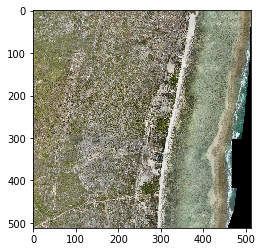

In [7]:
size=512
img1 = tiff.imread("tiffimg3.tif")
img1 = cv.resize(img1, (size, size))
plt.imshow(img1)

In [8]:
label_df = gpd.read_file("grid_029.geojson")
label_df = label_df[label_df['geometry'].isna() != True] 

<h3>the below format dataframe is what the GEOjson file for mask looks like. 
the geometry represents the polygon shape which represents where exactily in the image is the building. </h3>

In [9]:
label_df.head(10)

,id,changeset,problemati,condition,area,geometry
0,1,2017-08-15T06:47:50,None,Complete,132.4921875,"POLYGON ((39.34498 -5.85718, 39.34509 -5.85718..."
1,2,2017-08-15T06:49:19,None,Incomplete,123.75,"POLYGON ((39.34498 -5.85704, 39.34508 -5.85703..."
2,3,2017-08-15T06:50:32,None,Incomplete,167.98095703125,"POLYGON ((39.34536 -5.85699, 39.34536 -5.85700..."
3,4,2017-08-15T06:52:56,None,Foundation,45.55908203125,"POLYGON ((39.34501 -5.85683, 39.34510 -5.85683..."
4,5,2017-08-15T06:56:15,None,Complete,17.037109375,"POLYGON ((39.34553 -5.85718, 39.34553 -5.85719..."
5,6,2017-08-15T06:56:15,None,Incomplete,18.33056640625,"POLYGON ((39.34549 -5.85723, 39.34552 -5.85723..."
6,7,2017-08-15T06:58:30,None,Incomplete,138.80419921875,"POLYGON ((39.34556 -5.85742, 39.34555 -5.85752..."
7,8,2017-08-15T06:58:30,None,Incomplete,124.3583984375,"POLYGON ((39.34484 -5.85756, 39.34493 -5.85757..."
8,9,2017-08-15T07:00:21,None,Incomplete,62.8974609375,"POLYGON ((39.34508 -5.85770, 39.34517 -5.85770..."
9,10,2017-08-15T07:02:03,None,Incomplete,162.359375,"POLYGON ((39.34490 -5.85775, 39.34497 -5.85776..."


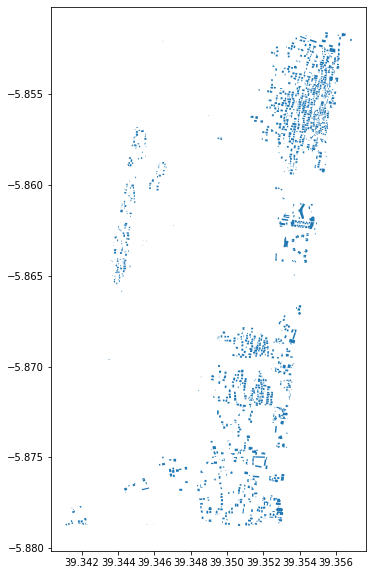

In [10]:
label_df.plot(figsize=(10,10))

<h4>In the following cells we are going to divide the image into two sections, one for training and the other for validaton. The concept of tiles will be introduced here. The tiff image
above will be divided into tiles. Tiles here are nothing but images which are relatively smaller in size than the original and if stiched together we will get the full image. These 
tiles are what we use for training the CNN,  There is also a concept of zoom level introduced here, basically we can zoom into the tiff image and as we increase the zoom level
the resolution of the image gets smaller. </h4>

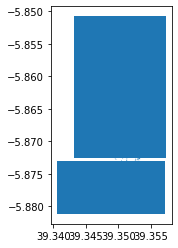

In [11]:
tile_size = 256
zoom_level = 19

aoi_df = gpd.read_file('val_trn.geojson')
aoi_df.plot()

The above image is a GEOjson plot for the original tiff image, and the larger portion is what we are going to use for training our CNN and the left portion will be used for validation. This task is already done for us 

In [13]:
aoi_df[aoi_df['dataset']=='train']['geometry'].to_file('trn_aoi.geojson', driver='GeoJSON')
aoi_df[aoi_df['dataset']=='valid']['geometry'].to_file('val_aoi.geojson', driver='GeoJSON')

In [14]:
import supermercado, mercantile

In [15]:
!type trn_aoi.geojson | supermercado burn {zoom_level} | mercantile shapes | fio collect > trn_aoi_z1{zoom_level}tiles.geojson
!type val_aoi.geojson | supermercado burn {zoom_level} | mercantile shapes | fio collect > val_aoi_z1{zoom_level}tiles.geojson

In [18]:
trn_tiles = gpd.read_file(f'trn_aoi_z1{zoom_level}tiles.geojson')
val_tiles = gpd.read_file(f'val_aoi_z1{zoom_level}tiles.geojson')
trn_tiles['dataset'] = 'trn'
val_tiles['dataset'] = 'val'

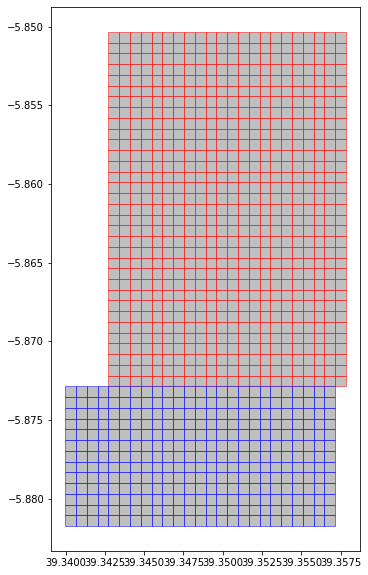

In [19]:
# see if there's overlapping tiles between trn and val
fig, ax = plt.subplots(figsize=(10,10))
trn_tiles.plot(ax=ax, color='grey', alpha=0.5, edgecolor='red')
val_tiles.plot(ax=ax, color='grey', alpha=0.5, edgecolor='blue')

In [20]:
# merge into one gdf to keep all trn tiles while dropping overlapping/duplicate val tiles
import pandas as pd
tiles_gdf = gpd.GeoDataFrame(pd.concat([trn_tiles, val_tiles], ignore_index=True), crs=trn_tiles.crs)
tiles_gdf.drop_duplicates(subset=['id'], inplace=True)

<h4> to make sure there is no overlapping in the edges </h4>

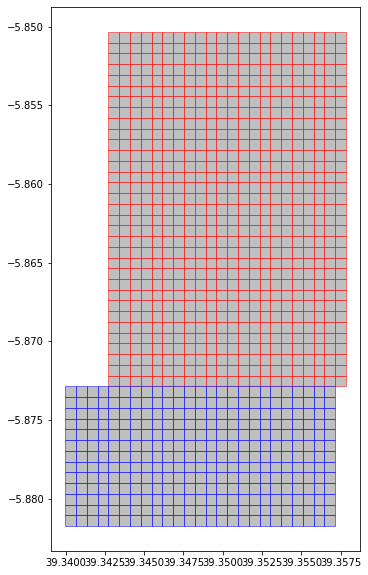

In [21]:
# check that there's no more overlapping tiles between trn and val
fig, ax = plt.subplots(figsize=(10,10))
tiles_gdf[tiles_gdf['dataset'] == 'trn'].plot(ax=ax, color='grey', edgecolor='red', alpha=0.5)
tiles_gdf[tiles_gdf['dataset'] == 'val'].plot(ax=ax, color='grey', edgecolor='blue', alpha=0.5)

In [22]:
tiles_gdf.head()

,id,title,geometry,dataset
0,"(319441, 270679, 19)","XYZ tile (319441, 270679, 19)","POLYGON ((39.34273 -5.85101, 39.34273 -5.85033...",trn
1,"(319442, 270679, 19)","XYZ tile (319442, 270679, 19)","POLYGON ((39.34341 -5.85101, 39.34341 -5.85033...",trn
2,"(319443, 270679, 19)","XYZ tile (319443, 270679, 19)","POLYGON ((39.34410 -5.85101, 39.34410 -5.85033...",trn
3,"(319444, 270679, 19)","XYZ tile (319444, 270679, 19)","POLYGON ((39.34479 -5.85101, 39.34479 -5.85033...",trn
4,"(319445, 270679, 19)","XYZ tile (319445, 270679, 19)","POLYGON ((39.34547 -5.85101, 39.34547 -5.85033...",trn


In [23]:
# convert 'id' string to list of ints for z,x,y

def reformat_xyz(tile_gdf):
  tile_gdf['xyz'] = tile_gdf.id.apply(lambda x: x.lstrip('(,)').rstrip('(,)').split(','))
  tile_gdf['xyz'] = [[int(q) for q in p] for p in tile_gdf['xyz']]
  return tile_gdf

<h4>in the below geodataframe the title column represnts the tile coordinates in the larger image from where the tile is taken. </h4>

In [24]:
tiles_gdf = reformat_xyz(tiles_gdf)
tiles_gdf.head()

,id,title,geometry,dataset,xyz
0,"(319441, 270679, 19)","XYZ tile (319441, 270679, 19)","POLYGON ((39.34273 -5.85101, 39.34273 -5.85033...",trn,"[319441, 270679, 19]"
1,"(319442, 270679, 19)","XYZ tile (319442, 270679, 19)","POLYGON ((39.34341 -5.85101, 39.34341 -5.85033...",trn,"[319442, 270679, 19]"
2,"(319443, 270679, 19)","XYZ tile (319443, 270679, 19)","POLYGON ((39.34410 -5.85101, 39.34410 -5.85033...",trn,"[319443, 270679, 19]"
3,"(319444, 270679, 19)","XYZ tile (319444, 270679, 19)","POLYGON ((39.34479 -5.85101, 39.34479 -5.85033...",trn,"[319444, 270679, 19]"
4,"(319445, 270679, 19)","XYZ tile (319445, 270679, 19)","POLYGON ((39.34547 -5.85101, 39.34547 -5.85033...",trn,"[319445, 270679, 19]"


In [25]:
from rio_tiler import main as rt_main

import mercantile
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

In [36]:
idx = 289
tiles_gdf.iloc[idx]['xyz']

[319444, 270692, 19]

<h4>we are using rio-tiler a geo library tool to extract the the tile of the image and the corresponding mask from the GEOtiff image.</h4>

In [37]:
tile, mask = rt_main.tile('tiffimg3.tif', *tiles_gdf.iloc[idx]['xyz'], tilesize=tile_size)

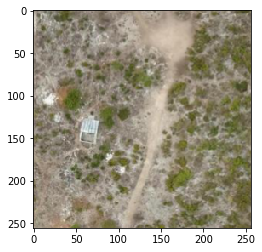

In [38]:
plt.imshow(np.moveaxis(tile,0,2))

In [39]:
all_polys = label_df.geometry

In [40]:
all_polys

0       POLYGON ((39.34498 -5.85718, 39.34509 -5.85718...
1       POLYGON ((39.34498 -5.85704, 39.34508 -5.85703...
2       POLYGON ((39.34536 -5.85699, 39.34536 -5.85700...
3       POLYGON ((39.34501 -5.85683, 39.34510 -5.85683...
4       POLYGON ((39.34553 -5.85718, 39.34553 -5.85719...
                              ...                        
1607    POLYGON ((39.35430 -5.86225, 39.35435 -5.86227...
1608    POLYGON ((39.35480 -5.86238, 39.35485 -5.86239...
1609    POLYGON ((39.35491 -5.86206, 39.35495 -5.86207...
1610    POLYGON ((39.35116 -5.87862, 39.35119 -5.87863...
1611    POLYGON ((39.34223 -5.87868, 39.34225 -5.87871...
Name: geometry, Length: 1612, dtype: geometry

In [41]:
# preemptively fix and merge any invalid or overlapping geoms that would otherwise throw errors during the rasterize step. 
# TODO: probably a better way to do this

# https://gis.stackexchange.com/questions/271733/geopandas-dissolve-overlapping-polygons
# https://nbviewer.jupyter.org/gist/rutgerhofste/6e7c6569616c2550568b9ce9cb4716a3

def explode(gdf):
    """    
    Will explode the geodataframe's muti-part geometries into single 
    geometries. Each row containing a multi-part geometry will be split into
    multiple rows with single geometries, thereby increasing the vertical size
    of the geodataframe. The index of the input geodataframe is no longer
    unique and is replaced with a multi-index. 

    The output geodataframe has an index based on two columns (multi-index) 
    i.e. 'level_0' (index of input geodataframe) and 'level_1' which is a new
    zero-based index for each single part geometry per multi-part geometry
    
    Args:
        gdf (gpd.GeoDataFrame) : input geodataframe with multi-geometries
        
    Returns:
        gdf (gpd.GeoDataFrame) : exploded geodataframe with each single 
                                 geometry as a separate entry in the 
                                 geodataframe. The GeoDataFrame has a multi-
                                 index set to columns level_0 and level_1
        
    """
    gs = gdf.explode()
    gdf2 = gs.reset_index().rename(columns={0: 'geometry'})
    gdf_out = gdf2.merge(gdf.drop('geometry', axis=1), left_on='level_0', right_index=True)
    gdf_out = gdf_out.set_index(['level_0', 'level_1']).set_geometry('geometry')
    gdf_out.crs = gdf.crs
    return gdf_out

def cleanup_invalid_geoms(all_polys):
  all_polys_merged = gpd.GeoDataFrame()
  all_polys_merged['geometry'] = gpd.GeoSeries(cascaded_union([p.buffer(0) for p in all_polys]))

  gdf_out = explode(all_polys_merged)
  gdf_out = gdf_out.reset_index()
  gdf_out.drop(columns=['level_0','level_1'], inplace=True)
  all_polys = gdf_out['geometry']
  return all_polys

all_polys = cleanup_invalid_geoms(all_polys)

In [42]:
all_polys

0       POLYGON ((39.34117 -5.87864, 39.34120 -5.87873...
1       POLYGON ((39.34223 -5.87868, 39.34225 -5.87871...
2       POLYGON ((39.34558 -5.87870, 39.34562 -5.87869...
3       POLYGON ((39.34597 -5.87872, 39.34594 -5.87872...
4       POLYGON ((39.34126 -5.87862, 39.34130 -5.87861...
                              ...                        
1588    POLYGON ((39.34422 -5.86107, 39.34426 -5.86107...
1589    POLYGON ((39.35418 -5.86102, 39.35429 -5.86107...
1590    POLYGON ((39.34421 -5.86100, 39.34423 -5.86100...
1591    POLYGON ((39.34433 -5.86097, 39.34436 -5.86097...
1592    POLYGON ((39.34488 -5.86090, 39.34497 -5.86092...
Name: geometry, Length: 1593, dtype: geometry

(39.34478759765625, -5.859889863069602, 39.34547424316406, -5.859206805186898)


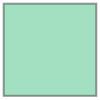

In [43]:
# get the same tile polygon as our tile image above
tile_poly = tiles_gdf.iloc[idx]['geometry']
print(tile_poly.bounds)
tile_poly

In [44]:
# get affine transformation matrix for this tile using rasterio.transform.from_bounds: https://rasterio.readthedocs.io/en/stable/api/rasterio.transform.html#rasterio.transform.from_bounds
tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 
tfm

Affine(2.682209014892578e-06, 0.0, 39.34478759765625,
       0.0, -2.668194854314049e-06, -5.859206805186898)

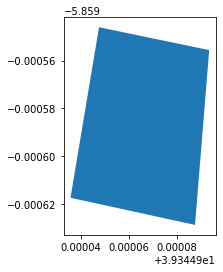

In [45]:
# crop znz001 geometries to what overlaps our tile polygon bounds
cropped_polys = [poly for poly in all_polys if poly.intersects(tile_poly)]
cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs=4326)
cropped_polys_gdf.plot()

In [57]:
#from https://solaris.readthedocs.io/en/latest/_modules/solaris/vector/mask.html

def df_to_px_mask(df, channels=["footprint"], out_file=None, reference_im=None,
                  geom_col='geometry', do_transform=None, affine_obj=None,
                  shape=(900, 900), out_type='int', burn_value=255, **kwargs):
    if isinstance(channels, str):  # e.g. if "contact", not ["contact"]
        channels = [channels]

    if out_file and not reference_im:
        raise ValueError(
            'If saving output to file, `reference_im` must be provided.')

    mask_dict = {}
    if 'footprint' in channels:
        mask_dict['footprint'] = footprint_mask(
            df=df, reference_im=reference_im, geom_col=geom_col,
            do_transform=do_transform, affine_obj=affine_obj, shape=shape,
            out_type=out_type, burn_value=burn_value
        )
    output_arr = np.stack([mask_dict[c] for c in channels], axis=-1)

    if reference_im:
        reference_im = _check_rasterio_im_load(reference_im)
    if out_file:
        meta = reference_im.meta.copy()
        meta.update(count=output_arr.shape[-1])
        meta.update(dtype='uint8')
        with rasterio.open(out_file, 'w', **meta) as dst:
            # I hate band indexing.
            for c in range(1, 1 + output_arr.shape[-1]):
                dst.write(output_arr[:, :, c-1], indexes=c)

    return output_arr

def footprint_mask(df, out_file=None, reference_im=None, geom_col='geometry',
                   do_transform=None, affine_obj=None, shape=(900, 900),
                   out_type='int', burn_value=255, burn_field=None):

    if len(df) == 0 and not out_file:
        return np.zeros(shape=shape, dtype='uint8')

    if do_transform is None:
        # determine whether or not transform should be done
        do_transform = _check_do_transform(df, reference_im, affine_obj)

#     df[geom_col] = df[geom_col].apply(_check_geom)  # load in geoms if wkt
    if not do_transform:
        affine_obj = Affine(1, 0, 0, 0, 1, 0)  # identity transform

    if reference_im:
        reference_im = _check_rasterio_im_load(reference_im)
        shape = reference_im.shape
        if do_transform:
            affine_obj = reference_im.transform
             # extract geometries and pair them with burn values
    if burn_field:
        if out_type == 'int':
            feature_list = list(zip(df[geom_col],
                                    df[burn_field].astype('uint8')))
        else:
            feature_list = list(zip(df[geom_col],
                                    df[burn_field].astype('float32')))
    else:
        feature_list = list(zip(df[geom_col], [burn_value]*len(df)))

    if len(df) > 0:
        output_arr = features.rasterize(shapes=feature_list, out_shape=shape,
                                        transform=affine_obj)
    else:
        output_arr = np.zeros(shape=shape, dtype='uint8')
    if out_file:
        meta = reference_im.meta.copy()
        meta.update(count=1)
        if out_type == 'int':
            meta.update(dtype='uint8')
            meta.update(nodata=0)
        with rasterio.open(out_file, 'w', **meta) as dst:
                 dst.write(output_arr, indexes=1)

    return output_arr



In [58]:
def _check_do_transform(df, reference_im, affine_obj):
    """Check whether or not a transformation should be performed."""
    try:
        crs = getattr(df, 'crs')
    except AttributeError:
        return False  # if it doesn't have a CRS attribute

    if not crs:
        return False  # return False for do_transform if crs is falsey
    elif crs and (reference_im is not None or affine_obj is not None):
        # if the input has a CRS and another obj was provided for xforming
        return True

In [59]:
# burn a footprint/boundary/contact 3-channel mask with solaris: https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_masks_tutorial.html
fbc_mask = df_to_px_mask(df=cropped_polys_gdf,
                                         channels=['footprint'],
                                         affine_obj=tfm, shape=(tile_size,tile_size),
                                         boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)

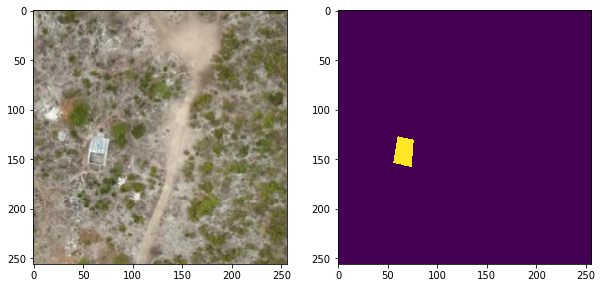

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
ax1.imshow(np.moveaxis(tile,0,2))
ax2.imshow(fbc_mask[:,:,0])

In [61]:
import skimage
from tqdm import tqdm
data_dir = Path('data/more')
data_dir.mkdir(exist_ok=True)

img_path = data_dir/'images-256'
mask_path = data_dir/'masks-256'
img_path.mkdir(exist_ok=True)
mask_path.mkdir(exist_ok=True)

In [126]:
cropped_polys_gdf['geometry']


0    POLYGON ((39.34590 -5.85970, 39.34591 -5.85968...
1    POLYGON ((39.34614 -5.85959, 39.34615 -5.85951...
2    POLYGON ((39.34611 -5.85935, 39.34614 -5.85935...
3    POLYGON ((39.34583 -5.85988, 39.34582 -5.85998...
4    POLYGON ((39.34616 -5.85928, 39.34609 -5.85926...
Name: geometry, dtype: geometry

In [62]:

def save_tile_img(url, xyz, tile_size, save_path='', prefix='', display=False):
    
        x,y,z = xyz
        tile, mask = rt_main.tile(url, x,y,z, tilesize=tile_size)
        skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}.png',np.moveaxis(tile,0,2), check_contrast=False) 
def save_tile_mask(labels_poly, tile_poly, xyz, tile_size, save_path='', prefix='', display=False):
    x,y,z = xyz
    tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 
  
    cropped_polys = [poly for poly in labels_poly if poly.intersects(tile_poly)]
    cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs=4326)
  
    fbc_mask = df_to_px_mask(df=cropped_polys_gdf,
                                         channels=['footprint'],
                                         affine_obj=tfm, shape=(tile_size,tile_size),
                                         boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)
  
    if display: plt.imshow(fbc_mask); plt.show()
  
    skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}_mask.png',fbc_mask, check_contrast=False) 

In [64]:

for idx, tile in tqdm(tiles_gdf.iterrows()):
    dataset = tile['dataset']
    save_tile_img('tiffimg3.tif', tile['xyz'], tile_size, save_path=img_path, prefix=f'znz001{dataset}_')

In [65]:
# TODO: multiprocess this? Took ~3 mins to burn and save 1261 masks
for idx, tile in tqdm(tiles_gdf.iterrows()):
    dataset = tile['dataset']
    tile_poly = tile['geometry']
    save_tile_mask(all_polys, tile_poly, tile['xyz'], tile_size, save_path=mask_path,prefix=f'znz001{dataset}_', display=False)

In [68]:
train_path = 'data/images-256'
train_images = [f for f in glob.glob(train_path + "*/*.png", recursive=True)]
print(len(train_images))

ground_t_path = 'data/masks-256'
train_masks= [f for f in glob.glob(ground_t_path + "*/*.png", recursive=True)]
print(len(train_masks))

1261
1261


# Now that we have images tiled into smaller sizes and corresponding masks  we can train any UNET network and segment buildings from image (the training and validation part is done in another notebook due to some dependency problems.)
